# Test EV control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from tqdm import tqdm
import scipy.stats as stats

In [2]:
# manually search perceptron hyperparameters for binary classification
import cProfile as profile
import pstats

In [3]:
# --- Response ---
from ev_ssm import ev_ssm
import numpy as np

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
             ict_off=False, ecc_off=False)
sse.load_A("Aest.csv")

evd0 = sse.ev.copy()

# quiet some EVs by force
# np.random.seed(sse.config["seed"])
# ict_rid = np.random.randint(low=0,
#                             high=sse.ev.shape[0],
#                             size=3000)

# sse.ev.na.iloc[ict_rid] = sse.ev.nam.iloc[ict_rid]
# sse.ev.lc.iloc[ict_rid] = 1
# sse.g_u()

# initial EV data
evd0 = sse.ev.copy()

sse.g_frc()

EVA: ts=18[H], 10000 EVs, Total Q=87.7 MWh
Online 2925, Q=73.03 MWh, SoC=0.7717
Power(MW): Pt=-7.9463, Pc=-7.9463, Pd=-0.0
Ctrl: 0=1584; 1=1341; 
EVA: Load A from Aest.csv.


[24.629258030047083, 1.8878967125704165]

In [4]:
prof = profile.Profile()
prof.enable()
for i in range(20):
        sse.run(tf=18 + i/3600, Pi=0.5*i,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
for i in range(20):
        sse.run(tf=18 + (20 + i)/3600, Pi=10 - 0.5*i,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
prof.disable()

EVA: end time 18.0[H] is too close to start time 18[H],simulation will not start.


(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

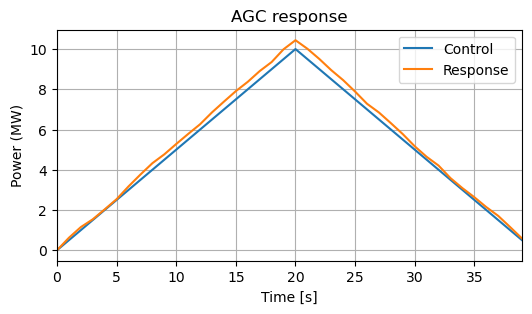

In [5]:
sse.plot_agc()

In [6]:
import time
tl = []
n = 10000
for i in range(n):
    t0 = time.time()
    idx = sse.ev[(sse.ev["u"].values == 1) & (sse.ev["c"] == 1)].index
    t = time.time() - t0
    tl.append(t)
print("n=", n, "mean[ms]=", 1e3 * np.mean(tl).round(4), "std[ms]=", 1e3*np.std(tl).round(4))

n= 10000 mean[ms]= 0.4 std[ms]= 0.1


In [7]:
import time
tl = []
n = 100
for i in range(n):
    Pi = 5 + np.random.uniform(low=-4, high=4, size=1)[0]
    t0 = time.time()
    sse.r_agc(Pi)
    t = time.time() - t0
    tl.append(t)
print("n=", n, "mean=", np.mean(tl).round(4), "std=", np.std(tl).round(4))

n= 100 mean= 0.0338 std= 0.0075


In [8]:
stats = pstats.Stats(prof).strip_dirs().sort_stats("tottime")
stats.print_stats(20)

         17438827 function calls (17399543 primitive calls) in 7.478 seconds

   Ordered by: internal time
   List reduced from 1192 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   742189    1.119    0.000    2.598    0.000 series.py:943(__getitem__)
4630233/4629525    0.556    0.000    0.709    0.000 {built-in method builtins.isinstance}
   754112    0.384    0.000    0.646    0.000 indexing.py:2481(check_deprecated_indexers)
   574052    0.351    0.000    1.073    0.000 generic.py:5577(__setattr__)
   277369    0.290    0.000    1.525    0.000 apply.py:976(series_generator)
   751600    0.249    0.000    0.402    0.000 series.py:687(_values)
       79    0.210    0.003    4.697    0.059 apply.py:856(apply_series_generator)
   289170    0.205    0.000    0.681    0.000 series.py:640(name)
   277290    0.196    0.000    2.762    0.000 ev_ssm.py:468(<lambda>)
   277290    0.189    0.000    0.223    0.000 managers.py:1884(set_valu